<h1 align="center">Volume 4: HIV Treatment.</h1>

Caelan Osman
Section 1
Feb 23, 2021

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#Code from RK4 Lab with minor edits
def initialize_all(y0, t0, t, n):
    """ An initialization routine for the different ODE solving
    methods in the lab. This initializes Y, T, and h. """
    if isinstance(y0, np.ndarray):
        Y = np.empty((n, y0.size)).squeeze()
    else:
        Y = np.empty(n)
    
    Y[0] = y0
    T = np.linspace(t0, t, n)
    h = float(t - t0) / (n - 1)
    return Y, T, h

def RK4(f, y0, t0, t, n):
    """ Use the RK4 method to compute an approximate solution
    to the ODE y' = f(t, y) at n equispaced parameter values from t0 to t
    with initial conditions y(t0) = y0.
    
    y0 is assumed to be either a constant or a one-dimensional numpy array.
    t and t0 are assumed to be constants.
    f is assumed to accept three arguments.
    The first is a constant giving the value of t.
    The second is a one-dimensional numpy array of the same size as y.
    The third is an index to the other arrays.
    
    This function returns an array Y of shape (n,) if
    y is a constant or an array of size 1.
    It returns an array of shape (n, y.size) otherwise.
    In either case, Y[i] is the approximate value of y at
    the i'th value of np.linspace(t0, t, n).
    """
    Y,T,h = initialize_all(y0,t0,t,n)
    for i in range(n-1):
        K1 = f(T[i],Y[i],i)
        K2 = f(T[i]+h/2.,Y[i]+h/2.*K1,i)
        K3 = f(T[i]+h/2.,Y[i]+h/2.*K2,i)
        K4 = f(T[i+1],Y[i]+h*K3,i)
        Y[i+1] = Y[i] + h/6.*(K1+2*K2 +2*K3+K4)
    return Y, T

# Problem 1

Create a function that defines the state equations and returns both equations in
a single array. The function should be able to be passed into the RK4 solver.

In [3]:
# define constants
a_1, a_2 = 0, 0
b_1, b_2 = 0.02, 0.9
s_1, s_2 = 2., 1.5
mu = 0.002
k = 0.000025    # The paper uses .00025, but it's hard to determine which solution actually makes sense.
g = 30.
c = 0.007
B_1, B_2 = 14, 1
A_1, A_2 = 250000, 75
T0, V0 = 400, 3
t_f = 50
n = 2000

# helper function to define global states
state = np.zeros((n, 2))
state0 = np.array([T0, V0])

costate = np.zeros((n, 2))
costate0 = np.zeros(2)
u = np.zeros((n, 2))
u[:, 0] += b_1
u[:, 1] += b_2

# define state equations
def state_equations(t,y,i):
    '''
    Parameters
    ---------------
    t : float
        the time
    y : ndarray (2,)
        the T cell concentration and the Virus concentration at time t
    i : int
        index for the global variable u.
    
    Returns
    --------------
    y_dot : ndarray (2,)
            the derivative of the T cell concentration and the virus
            concentration at time t
    '''
    # calculate current derivatives
    dTdt = s_1 - (s_2*y[1]) / (B_1 + y[1]) - mu*y[0] - k*y[1]*y[0] + u[i, 0]*y[0]
    dVdt = ((g*y[1]) / (B_2 + y[1]))*(1 - u[i, 1]) - c*y[1]*y[0]
    # return corresponding array
    return np.array([dTdt, dVdt])

# Problem 2

Create a function that defines the costate equations and returns both equations
in a single array. The function should be able to be passed into the RK4 solver. Use the global
variables as defined in Problem 1.

In [4]:
def lambda_hat(t,y,i):
    '''
    Parameters
    ---------------
    t : float
    the time
    y : ndarray (2,)
    the lambda_hat values at time t
    i : int
    index for global variables, u and state.
    Returns
    --------------
    y_dot : ndarray (2,)
    the derivative of the lambda_hats at time t.
    '''

    dLam1dt = y[0]*(-mu - k*state[n-i-1, 1] + u[n-i-1, 0]) - c*y[1]*state[n-i-1, 1] + 1
    dLam2dt = -y[0]*((s_2*B_1) /((B_1 + state[n-i-1, 1])**2) + k*state[n-i-1, 0])\
              + y[1]*((g*B_2*(1 - u[n-i-1, 1])) / ((B_2 + state[n-i-1, 1])**2) - c*state[n-i-1, 0])

    return np.array([dLam1dt, dLam2dt])

# Problem 3

Create and run a numerical solver for the HIV two drug model. Plot the solution.

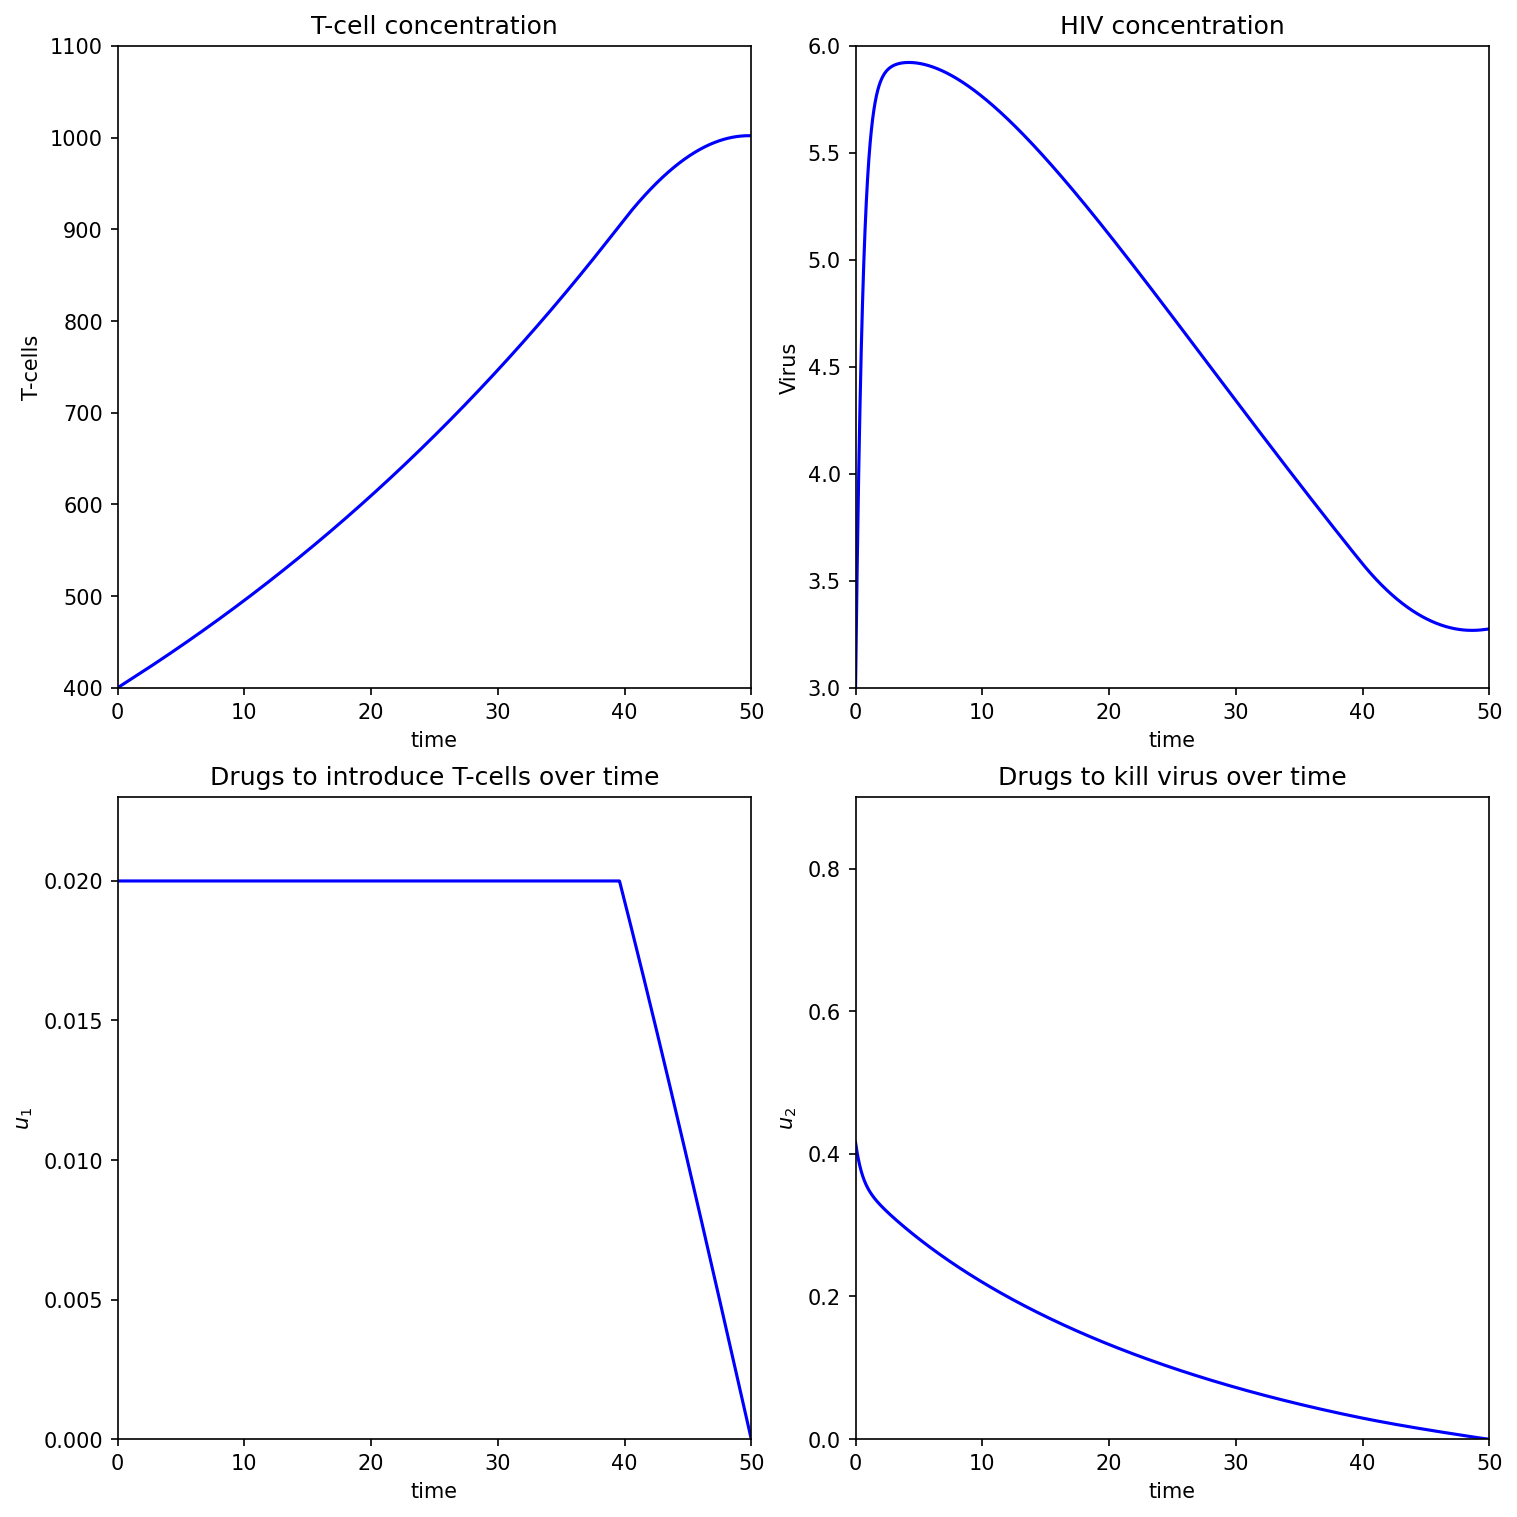

In [5]:
epsilon = 0.001
test = epsilon + 1
while(test > epsilon):
    old_u = u.copy()
    
    #solve the state equations with forward iteration
    #state = RK4(...)
    state, T = RK4(state_equations, state0, 0, t_f, n)
    #solve the costate equations with backwards iteration
    #costate = RK4(...)[::-1]

    costate, _ = RK4(lambda_hat, costate0, 0, t_f, n)
    costate = costate[::-1]

    #solve for u1 and u2
    u1 = np.array([min(max(a_1, (l1*t)/(2*A_1)), b_1) for l1, t in zip(costate[:, 0], state[:, 0])])
    u2 = np.array([min(max(a_2, (-l2*g*v)/(2*A_2*(B_2 + v))), b_2) for l2, v in zip(costate[:, 1], state[:, 1])])

    #update control
    u[:,0] = 0.5*(u1 + old_u[:,0])
    u[:,1] = 0.5*(u2 + old_u[:,1])
    
    #test for convergence
    test = abs(old_u - u).sum()

# now we plot
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(10, 10))
fig.set_dpi(150)

ax = axs[0, 0]
ax.plot(T, state[:, 0], 'b-')
ax.set_xlabel("time")
ax.set_ylabel("T-cells")
ax.set_title('T-cell concentration')
ax.axis([0, 50, 400, 1100])

ax = axs[0, 1]
ax.plot(T, state[:, 1], 'b-')
ax.set_xlabel("time")
ax.set_ylabel("Virus")
ax.set_title('HIV concentration')
ax.axis([0, 50, 3.0, 6.0])

ax = axs[1, 0]
ax.plot(T, u[:, 0], 'b-')
ax.set_xlabel("time")
ax.set_ylabel(r"$u_1$")
ax.set_title('Drugs to introduce T-cells over time')
ax.axis([0, 50, 0.00, 0.023])
ax.set_yticks([0.000, 0.005, 0.010, 0.015, 0.020])

ax = axs[1, 1]
ax.plot(T, u[:, 1], 'b-')
ax.set_xlabel("time")
ax.set_ylabel(r"$u_2$")
ax.set_title('Drugs to kill virus over time')
ax.axis([0, 50, 0.0, 0.9])
ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8])
plt.show()